# Analysis of Osth & Fox (2019)

## Read raw data and get test trials

In [1]:
import polars as pl
import seaborn as sns
from project import task
data_file = task.get_data_file()
raw = task.read_data(data_file)
df = raw.filter(pl.col("phase") == "test")
df.head()

subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
i64,i64,i64,str,str,str,str,i64,f64,i64,i64
101,0,-1,"""test""","""rearranged""","""waste""","""degree""",0,2.312,1,2
101,0,0,"""test""","""rearranged""","""needed""","""able""",0,3.542,1,1
101,0,1,"""test""","""rearranged""","""single""","""clean""",0,2.084,1,3
101,0,2,"""test""","""rearranged""","""train""","""useful""",0,1.669,1,2
101,0,3,"""test""","""rearranged""","""knees""","""various""",0,2.326,1,5


## Exclude responses that were too fast
If a response took place in less than 0.2 s, then it was probably an accidental response.

In [2]:
df_filt = task.exclude_fast_responses(df, thresh=0.2)
prev_null = df["RT"].is_null().sum()
null = df_filt["RT"].is_null().sum()
print(f"Excluded {null - prev_null} short responses.")
df_filt.describe()

Excluded 76 short responses.


statistic,subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64
"""count""",53700.0,53700.0,53700.0,"""53700""","""53700""","""53700""","""53700""",53571.0,53571.0,53700.0,26850.0
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",129.0,129.0,0.0,26850.0
"""mean""",165.655866,3.496089,28.5,null,null,null,null,0.37384,1.335209,0.656648,3.0
"""std""",99.008229,2.289598,17.318264,null,null,null,null,0.483827,0.756055,0.474832,1.41424
"""min""",101.0,0.0,-1.0,"""test""","""intact""","""ability""","""ability""",0.0,0.212,0.0,1.0
"""25%""",128.0,1.0,14.0,null,null,null,null,0.0,0.883,0.0,2.0
"""50%""",158.0,3.0,29.0,null,null,null,null,0.0,1.126,1.0,3.0
"""75%""",186.0,5.0,43.0,null,null,null,null,1.0,1.527,1.0,4.0
"""max""",1150.0,7.0,58.0,"""test""","""rearranged""","""youth""","""youth""",1.0,7.925,1.0,5.0


In [3]:
(
    df_filt.group_by("subj", "type")
    .agg(pl.col("response").mean())
    .group_by("type")
    .agg(pl.col("response").mean())
)

type,response
str,f64
"""intact""",0.531784
"""rearranged""",0.216304


In [4]:
resp = (
    df_filt.group_by("subj", "type")
    .agg(pl.col("response").mean())
    .sort("subj", "type")
)
tab = (
    resp.pivot("type", index="subj", values="response")
    .select(subj="subj", hr="intact", far="rearranged")
)
tab

subj,hr,far
i64,f64,f64
101,0.76569,0.108333
102,0.2875,0.241667
103,0.866667,0.091667
104,0.508333,0.3875
105,0.575,0.372385
…,…,…
210,0.209205,0.15
211,0.495833,0.179167
212,0.564854,0.52766


<Axes: xlabel='type', ylabel='response'>

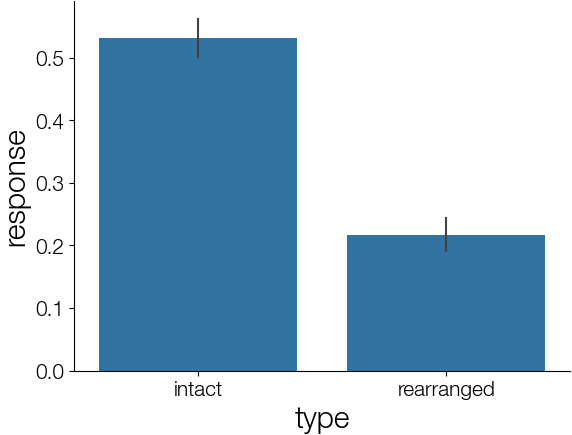

In [5]:
sns.barplot(resp, x="type", y="response")

In [6]:
resp_lag = (
    df_filt.filter(pl.col("type") == "rearranged")
    .group_by("subj", "lag")
    .agg(pl.col("response").mean())
    .sort("subj", "lag")
)
resp_lag

subj,lag,response
i64,i64,f64
101,1,0.0625
101,2,0.1875
101,3,0.0625
101,4,0.125
101,5,0.104167
…,…,…
1150,1,0.270833
1150,2,0.1875
1150,3,0.166667


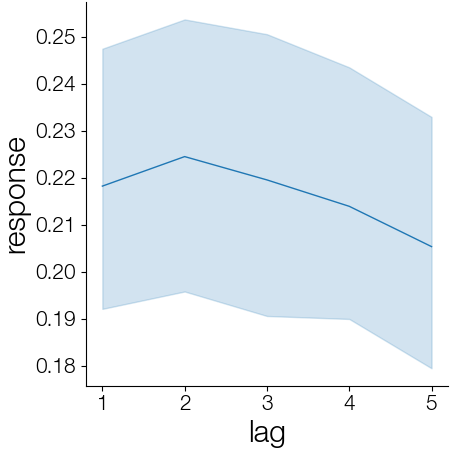

In [7]:
sns.relplot(resp_lag, x="lag", y="response", kind="line")